# Oxford Pet 데이터셋에 대한 Object Localization실습 예제
본 코드는 "텐서플로 딥러닝 프로그래밍" (가메출판사) 책에 실려 있는 예제코드임.

# Oxford Pet 데이터셋 다운로드

다음 사이트에 가서 이미지와 annotations을 다운로드받으면 됨
이미지는 Dataset링크에서 받으면 되고, annotations은 Groundtruth data링크에서 받으면 됨.

https://www.robots.ox.ac.uk/~vgg/data/pets

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving images.tar.gz to images.tar.gz


TypeError: ignored

In [2]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz #이미지를 다운로드
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz #annotations를 다운로드

--2021-02-01 09:56:12--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  6.74MB/s    in 1m 53s  

2021-02-01 09:58:06 (6.70 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2021-02-01 09:58:06--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19173078 (18M) [application/x-gzip]
Saving to: ‘annotations.tar.gz’

annotations.tar.gz  100%[===================>]  18.28M  17.9MB/s    in 1.0s    

2021-02-01 09:58:07 (17.9 M

In [3]:
# images.tar.gz파일 앞축풀기
!tar -xf images.tar.gz

In [4]:
ls

annotations.tar.gz  images/  images.tar.gz  sample_data/


In [5]:
# annotations.tar.gz파일 압축풀기
!tar -xf annotations.tar.gz

In [6]:
ls

annotations/  annotations.tar.gz  images/  images.tar.gz  sample_data/


In [16]:
# 기본 세팅
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image # pip install pillow
import os

import xml.etree.ElementTree as ET
import cv2  # 만약 OpenCV가 설치되어 있지 않았다면 pip install opencv_python 로 설치를 먼저해야 함

import tensorflow as tf
from tensorflow.keras.layers   import Input, Dense, Flatten
from tensorflow.keras.layers   import Conv2D, BatchNormalization,MaxPool2D, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop


In [17]:
#GPU메모리 부족현상을 해결하기 위해
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [9]:
#xml파일에서 Bounding Box를 추출하는 함수
def getBB(file_path):
  try:
    tree = ET.parse(file_path)
  except FileNotFoundError:
    return None  
  root = tree.getroot()  
  ob = root.find('object')
  bndbox = ob.find('bndbox')
  xmin = bndbox.find('xmin').text
  xmax = bndbox.find('xmax').text
  ymin = bndbox.find('ymin').text
  ymax = bndbox.find('ymax').text
  return [int(xmin), int(ymin), int(xmax), int(ymax)]

[Bounding Box from XML]<img src='https://drive.google.com/uc?id=12h7vEb0HLgHCbETgggQ70PVPDispKwEG'>

[Bounding Box from XML]<img src='https://drive.google.com/uc?id=1T1489XS1Iq2RHYYFzwVD5kFHpYcsglHg'>

In [10]:
# oxford_pets 데이터파일을 열어서 test dataset과 training dataset만드는 함수
def load_oxford_pets_3(target_size= (224, 224)):
#    input_file = "./Oxford_Pets/annotations/list.txt"
    input_file = "./annotations/list.txt"

    file = open(input_file)
    list_txt = file.readlines()
    file.close()
    
    list_txt = list_txt[6:]     # delete header
    np.random.shuffle(list_txt)

    # load dataset
    train_dataset= {"name": [], "label": [], "image": [ ], "box": [] }
    test_dataset = {"name": [], "label": [], "image": [ ]}

    for line in list_txt:    
        image_name, class_id, species, breed_id = line.split()
#        image_file= "./Oxford_Pets/images/"+ image_name + ".jpg"
#        box_file  = "./Oxford_Pets/annotations/xmls/"+ image_name + ".xml"     
        image_file= "./images/"+ image_name + ".jpg"
        box_file  = "./annotations/xmls/"+ image_name + ".xml"     

        if not os.path.exists(image_file):
            continue

        # read image and scale to target_size
        img = image.load_img(image_file) # read as original size
        sx = target_size[0]/img.width    # for rescaling BB
        sy = target_size[1]/img.height
            
        img = img.resize(size=target_size)
        img = image.img_to_array(img)  # (224, 224, 3)
          
        if  os.path.exists(box_file): # train_dataset
            # read xml, rescale box by target_size   
            box = getBB(box_file)
            box[0] = round(box[0]*sx) # scale xmin with sx
            box[1] = round(box[1]*sy) # scale ymin with sy
            box[2] = round(box[2]*sx) # scale xmax with sx
            box[3] = round(box[3]*sy) # scale ymax with sy
            train_dataset["box"].append(box)
            train_dataset["name"].append(image_name)
            train_dataset["label"].append(int(species)-1)
            train_dataset["image"].append(img)          
            
        else: #test_dataset
            test_dataset["name"].append(image_name)
            test_dataset["label"].append(int(species)-1)
            test_dataset["image"].append(img)        
    # change list to np.array
    train_dataset["image"] = np.array(train_dataset["image"])
    train_dataset["box"]  = np.array(train_dataset["box"])
    train_dataset["label"] = np.array(train_dataset["label"])
    train_dataset["name"]  = np.array(train_dataset["name"])

    test_dataset["image"] = np.array(test_dataset["image"])
    test_dataset["label"] = np.array(test_dataset["label"])
    test_dataset["name"]  = np.array(test_dataset["name"])    
    return train_dataset, test_dataset

In [11]:
#load_oxford_pets_3()함수를 호출하여 train_dataset과 test_dataset만들기
train_dataset, test_dataset = load_oxford_pets_3()
print("train_dataset['image'].shape=", train_dataset['image'].shape)# (5880, 224, 224, 3)

#normalize 
x_train = train_dataset["image"]/255.0
y_train = train_dataset["box"]/x_train.shape[1] # [0, 224] -> [0, 1]
x_test  = test_dataset["image"]/255.0

train_dataset['image'].shape= (3671, 224, 224, 3)


In [12]:
# IOU를 계산하는 함수 
def IOU(y_true, y_pred):   

    b1_xmin, b1_ymin, b1_xmax, b1_ymax = tf.unstack(y_true, 4, axis=-1)
    b2_xmin, b2_ymin, b2_xmax, b2_ymax = tf.unstack(y_pred, 4, axis=-1)

    zero = tf.convert_to_tensor(0.0, y_true.dtype) # zero = 0.0      
    b1_width  = tf.maximum(zero, b1_xmax - b1_xmin)
    b1_height = tf.maximum(zero, b1_ymax - b1_ymin)
    b2_width  = tf.maximum(zero, b2_xmax - b2_xmin)
    b2_height = tf.maximum(zero, b2_ymax - b2_ymin)

    b1_area = b1_width * b1_height
    b2_area = b2_width * b2_height

    intersect_ymin = tf.maximum(b1_ymin, b2_ymin)
    intersect_xmin = tf.maximum(b1_xmin, b2_xmin)
    intersect_ymax = tf.minimum(b1_ymax, b2_ymax)
    intersect_xmax = tf.minimum(b1_xmax, b2_xmax)
    
    intersect_width = tf.maximum(zero, intersect_xmax - intersect_xmin)
    intersect_height = tf.maximum(zero, intersect_ymax - intersect_ymin)
    intersect_area = intersect_width * intersect_height

    union_area = b1_area + b2_area - intersect_area
    iou = intersect_area/union_area # tf.math.divide_no_nan(intersect_area, union_area)
    return iou

In [13]:
#  cnn model을 만들기
def create_cnn2d(input_shape, num_units = 4):
    inputs = Input(shape = input_shape)
    x= Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu')(inputs)
    x= BatchNormalization()(x)
    x= MaxPool2D()(x)

    x= Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu')(x)
    x= BatchNormalization()(x)
    x= MaxPool2D()(x)
    x= Dropout(rate = 0.2)(x)

    x= Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu')(x)
    x= BatchNormalization()(x)    
    x= MaxPool2D()(x)
    x= Dropout(rate = 0.2)(x)
    
    x = Flatten()(x)
    x = Dense(128, activation = 'relu')(x)
    x= BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    outputs = tf.keras.layers.Dense(units = num_units, activation = 'sigmoid')(x)
    model = tf.keras.Model(inputs = inputs, outputs = outputs)
    return model
    
model = create_cnn2d(input_shape = x_train.shape[1:])

115/115 - 2s - loss: 0.0032 - IOU: 0.7276


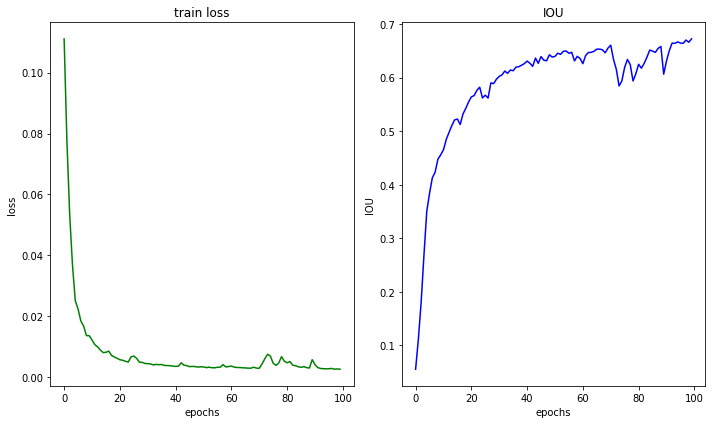

In [14]:
# 모델을 학습하기

opt = RMSprop(learning_rate = 0.001)
model.compile(optimizer = opt, loss = 'mse', metrics = [IOU])
ret = model.fit(x_train, y_train, epochs =100, batch_size =128, verbose = 0)

train_loss, train_acc = model.evaluate(x_train, y_train, verbose=2)

#6: plot accuracy and loss
fig, ax = plt.subplots(1, 2, figsize = (10, 6))
ax[0].plot(ret.history['loss'], "g-")
ax[0].set_title('train loss')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')

ax[1].plot(ret.history['IOU'], "b-")
ax[1].set_title('IOU')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('IOU')
fig.tight_layout()
plt.show()

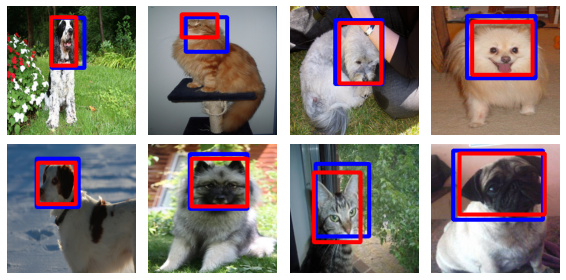

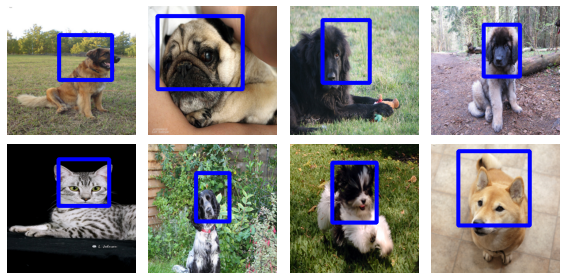

In [15]:
# k개의 샘플에 대해 예측하고, 결과를 보여주기
k = 8
train_box = model.predict(x_train[:k])
test_box = model.predict(x_test[:k])

def display_images(img, pred_box, true_box=None, size= 224):
    box = pred_box*size
    box = box.astype(int)
    k =  pred_box.shape[0]
    fig = plt.figure(figsize=(8, k//2))

    for i in range(k):
        plt.subplot(k//4, 4, i+1)

        a_img = (img[i]*255).astype('uint8')

        # box predicted
        xmin, ymin, xmax, ymax = box[i]           
        cv2.rectangle(a_img, (xmin, ymin), (xmax, ymax), (0, 0, 255), 5)

        if true_box is not None: # true box in case of train data
            xmin, ymin, xmax, ymax = true_box[i]
            cv2.rectangle(a_img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 5)
        plt.imshow(a_img)
        plt.axis("off")
    fig.tight_layout()
    plt.show()

display_images(x_train[:k], train_box, train_dataset["box"][:k])
display_images(x_test[:k],  test_box)
